1 ['deep', 'learning', 'known', 'as']  ->  also
2 ['learning', 'also', 'as', 'deep']  ->  known
3 ['also', 'known', 'deep', 'structured']  ->  as
4 ['known', 'as', 'structured', 'learning']  ->  deep
5 ['as', 'deep', 'learning', 'is']  ->  structured
6 ['deep', 'structured', 'is', 'part']  ->  learning
7 ['structured', 'learning', 'part', 'of']  ->  is
8 ['learning', 'is', 'of', 'a']  ->  part
9 ['is', 'part', 'a', 'broader']  ->  of
10 ['part', 'of', 'broader', 'family']  ->  a
11 ['of', 'a', 'family', 'of']  ->  broader
12 ['a', 'broader', 'of', 'machine']  ->  family
13 ['broader', 'family', 'machine', 'learning']  ->  of
14 ['family', 'of', 'learning', 'methods']  ->  machine
15 ['of', 'machine', 'methods', 'based']  ->  learning


C:\Users\91721\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


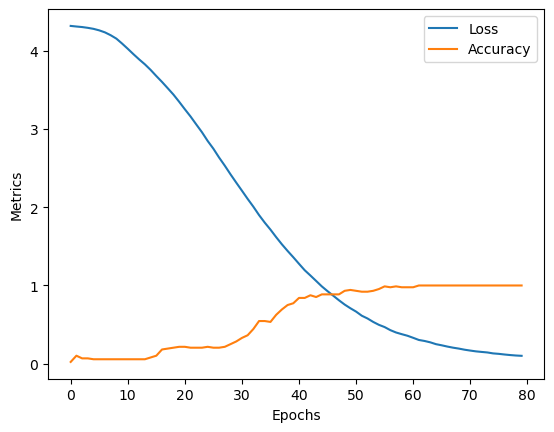

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Input: 'known as structured learning' -> Predicted next word: 'deep'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input: 'transformers have applied to' -> Predicted next word: 'been'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input: 'where they produced results' -> Predicted next word: 'have'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input: 'cases surpassing expert performance' -> Predicted next word: 'human'


In [14]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
import seaborn as sns
import matplotlib.pyplot as plt

# Sample text data
data = """Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised. Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks, convolutional neural networks and Transformers have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, climate science, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance."""

# Split data into sentences and preprocess
sentences = data.split('.')
clean_sentences = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence:  # Skip empty sentences
        sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence).strip().lower()
        clean_sentences.append(sentence)

# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_sentences)
sequences = tokenizer.texts_to_sequences(clean_sentences)

# Mapping index to word and word to index
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
word_to_index = tokenizer.word_index

# Create context and target pairs for training
vocab_size = len(tokenizer.word_index) + 1
emb_size = 10
context_size = 2

contexts = []
targets = []

for sequence in sequences:
    for i in range(context_size, len(sequence) - context_size):
        target = sequence[i]
        context = [sequence[i - 2], sequence[i - 1], sequence[i + 1], sequence[i + 2]]
        contexts.append(context)
        targets.append(target)

# Display first 5 context-target pairs
for i in range(15):
    context_words = [index_to_word.get(idx) for idx in contexts[i]]
    target_word = index_to_word.get(targets[i])
    print(i+1,context_words, " -> ", target_word)

# Prepare data for the model
X = np.array(contexts)
Y = np.array(targets)

# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, input_length=2 * context_size),
    Lambda(lambda x: tf.reduce_mean(x, axis=1)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=80, verbose=0)  

# Plot training loss and accuracy
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Loss')
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

# Test model predictions with sample sentences
test_sentences = [
    "known as structured learning",
    "transformers have applied to",
    "where they produced results",
    "cases surpassing expert performance"
]

for sentence in test_sentences:
    test_sequence = [word_to_index.get(word, 0) for word in sentence.split()]
    test_sequence = np.array([test_sequence])
    
    prediction = model.predict(test_sequence)
    predicted_word_index = np.argmax(prediction[0])
    predicted_word = index_to_word.get(predicted_word_index, "Unknown")
    
    print(f"Input: '{sentence}' -> Predicted next word: '{predicted_word}'")
